In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./kaggle/input/hate-speech-and-offensive-language-detection/.DS_Store
./kaggle/input/hate-speech-and-offensive-language-detection/train.csv


# Steps:
1) preprocessing
2) splitting
3) tokenize & padding
4) Create model & train
5) evaluate

# Preprocessing (cleaning the datasets):

1) remove html entity
2) change user tags (@xxx -> user)
3) remove urls
4) remove unnecessary symbol ('', !, ", ') -> cause a lot of noise in the dataset
5) remove stopwords

# 1| Import libraries

In [3]:
import pandas as pd # read the csv
import re # regex to detect username, url, html entity 
import nltk # to use word tokenize (split the sentence into words)
from nltk.corpus import stopwords # to remove the stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

from keras.utils import to_categorical
from keras import backend as K

In [4]:
import nltk
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/deepakkumar/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# 2| read the data

In [5]:
data = pd.read_csv("./kaggle/input/hate-speech-and-offensive-language-detection/train.csv")

data.head()

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [6]:
# dataset shape to know how many tweets in the datasets
print(f"num of tweets: {data.shape}")

# extract the text and labels
tweet = list(data['tweet'])
labels = list(data['class'])

num of tweets: (24783, 6)


# 3| functions to clean the data

In [7]:
#notes : all of the function taking 1 text at a time
stop_words = set(stopwords.words('english'))
# add rt to remove retweet in dataset (noise)
stop_words.add("rt")

# remove html entity:
def remove_entity(raw_text):
    entity_regex = r"&[^\s;]+;"
    text = re.sub(entity_regex, "", raw_text)
    return text

# change the user tags
def change_user(raw_text):
    regex = r"@([^ ]+)"
    text = re.sub(regex, "user", raw_text)

    return text

# remove urls
def remove_url(raw_text):
    url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    text = re.sub(url_regex, '', raw_text)

    return text

# remove unnecessary symbols
def remove_noise_symbols(raw_text):
    text = raw_text.replace('"', '')
    text = text.replace("'", '')
    text = text.replace("!", '')
    text = text.replace("`", '')
    text = text.replace("..", '')

    return text

# remove stopwords
def remove_stopwords(raw_text):
    tokenize = nltk.word_tokenize(raw_text)
    text = [word for word in tokenize if not word.lower() in stop_words]
    text = " ".join(text)
    return text

## this function in to clean all the dataset by utilizing all the function above
def preprocess(datas):
    clean = []
    # change the @xxx into "user"
    clean = [change_user(text) for text in datas]
    # remove emojis (specifically unicode emojis)
    clean = [remove_entity(text) for text in clean]
    # remove urls
    clean = [remove_url(text) for text in clean]
    # remove trailing stuff
    clean = [remove_noise_symbols(text) for text in clean]
    # remove stopwords
    clean = [remove_stopwords(text) for text in clean]

    return clean

In [8]:
# call the cleaning function
clean_tweet = preprocess(tweet)

In [9]:
text = ["hello himanshu my name is deepak", "how are you"]
preprocess(text)

['hello himanshu name deepak', '']

In [10]:
preprocess(["how are you"])

['']

# 4| Splitting the dataset into test and validation

In [11]:
X_train, X_test, y_train, y_test = train_test_split(clean_tweet, labels, test_size=0.2, random_state=42)

In [12]:
## Tokenizing -> basically we use tokenisation for many things, its commonly used for feature extraction in preprocessing. btw idk how it works as feature extraction tho :(
# declare the tokenizer
tokenizer = Tokenizer()
# build the vocabulary based on train dataset
tokenizer.fit_on_texts(X_train)
# tokenize the train and test dataset
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# vocabulary size (num of unique words) -> will be used in embedding layer
vocab_size = len(tokenizer.word_index) + 1

In [13]:
## Padding -> to uniform the datas
max_length = max(len(seq) for seq in X_train)

# to test an outlier case (if one of the test dataset has longer length)
for x in X_test:
    if len(x) > max_length:
        print(f"an outlier detected: {x}")

X_train = pad_sequences(X_train, maxlen = max_length)
X_test = pad_sequences(X_test, maxlen = max_length)

In [14]:
X_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          1,    1,  125,  407,   56,  479,   12,  154,  542, 8364,  689,
       1471,  215,  532,  130], dtype=int32)

In [15]:
vocab_size, max_length

(18671, 26)

In [16]:
y_test = to_categorical(y_test, num_classes=3)
y_train = to_categorical(y_train, num_classes=3)

In [17]:
y_train

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [18]:
# another look on the number of tweet in test and training data

print(f"num test tweet: {y_test.shape[0]}")
print(f"num train tweet: {y_train.shape[0]}")

num test tweet: 4957
num train tweet: 19826


# 5| Building the model

In [19]:
import numpy as np

def recall(y_true, y_pred):
    # Clip predictions to the range [0, 1] and round them
    y_pred = np.clip(y_pred, 0, 1)
    y_pred = np.round(y_pred)
    
    # Calculate true positives and possible positives
    true_positives = np.sum(y_true * y_pred)
    possible_positives = np.sum(y_true)
    
    # Calculate recall
    recall = true_positives / (possible_positives + np.finfo(float).eps)
    return recall

def precision(y_true, y_pred):
    # Clip predictions to the range [0, 1] and round them
    y_pred = np.clip(y_pred, 0, 1)
    y_pred = np.round(y_pred)
    
    # Calculate true positives and predicted positives
    true_positives = np.sum(y_true * y_pred)
    predicted_positives = np.sum(y_pred)
    
    # Calculate precision
    precision = true_positives / (predicted_positives + np.finfo(float).eps)
    return precision

def f1(y_true, y_pred):
    # Calculate precision and recall
    precisions = precision(y_true, y_pred)
    recalls = recall(y_true, y_pred)
    
    # Calculate F1 score
    f1_score = 2 * ((precisions * recalls) / (precisions + recalls + np.finfo(float).eps))
    return f1_score


In [20]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

# Register the custom metric
@tf.keras.utils.register_keras_serializable()
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# Optionally, register the custom metric so you can reference it by name
get_custom_objects().update({"f1_score": F1Score})


In [21]:
from tensorflow.keras.metrics import Precision, Recall

# change dis if u want
output_dim = 200

# LSTM model architechture (CNN + LSTM)
model = Sequential([
    # embedding layer is like idk
    Embedding(vocab_size, output_dim, input_length=max_length),
    # lstm for xxx
    LSTM(64, dropout=0.3, recurrent_dropout=0.3),
    # dropout to prevent overfitting
    Dropout(0.5),
    # dense to connect the previous output with current layer
    Dense(128, activation="relu"),
    # dropout to prevent overfitting
    Dropout(0.5),
    # this is output layer, with 3 class (0, 1, 2)
    Dense(3, activation="softmax"),
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

/opt/anaconda3/envs/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [22]:
# checking the model parameters
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Train the model
model_history = model.fit(
    X_train,
    y_train,
    batch_size = 64,
    epochs=2,
    validation_data=(X_test, y_test)
)

Epoch 1/2
310/310 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.7894 - loss: 0.6214 - precision: 0.8135 - recall: 0.6948 - val_accuracy: 0.8892 - val_loss: 0.3286 - val_precision: 0.9037 - val_recall: 0.8745
Epoch 2/2
310/310 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.9146 - loss: 0.2635 - precision: 0.9263 - recall: 0.9056 - val_accuracy: 0.8894 - val_loss: 0.3103 - val_precision: 0.8986 - val_recall: 0.8792


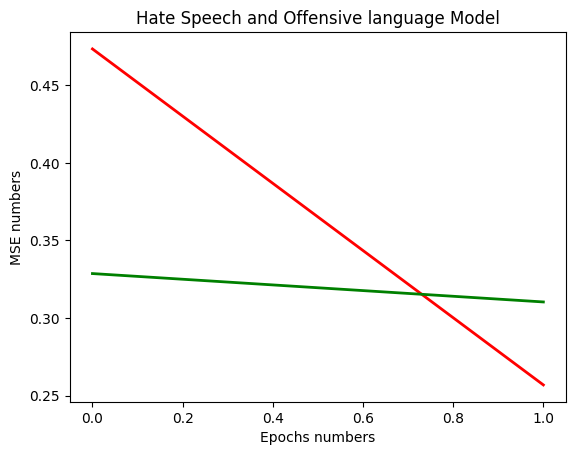

In [24]:
import matplotlib.pyplot as plt
hist = model.history.history
plt.plot(hist['loss'],'r',linewidth=2, label='Training loss')
plt.plot(hist['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('Hate Speech and Offensive language Model')
plt.xlabel('Epochs numbers')
plt.ylabel('MSE numbers')
plt.show()

# Saving the model

In [25]:
# Save the entire model
model.save('./saved_model/my_model.keras')

In [26]:
import pickle

# Save the tokenizer
with open('./saved_model/tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)
